In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy import genfromtxt
from scipy.stats import norm
from random import choices
from matplotlib.pyplot import cm

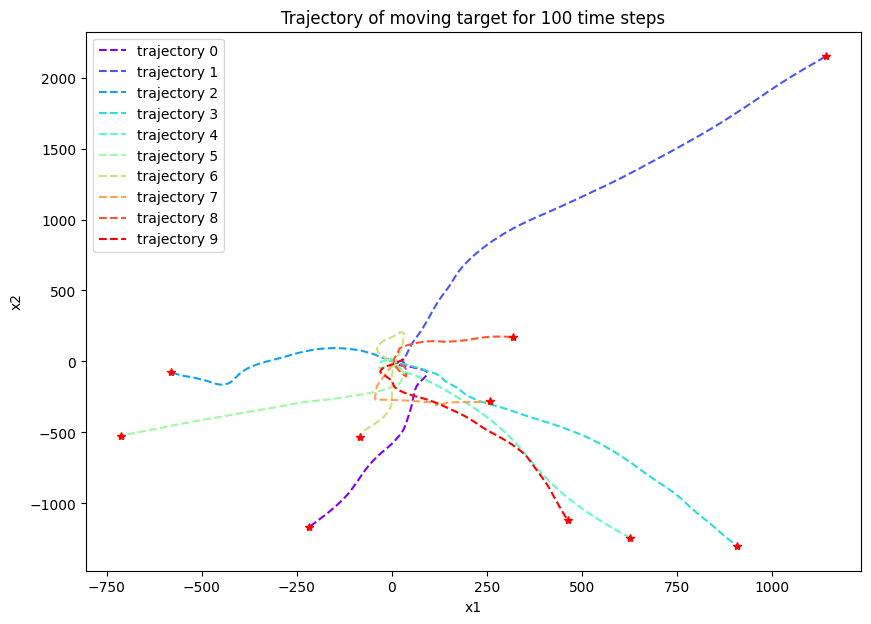

In [ ]:
# P1 - simulate trajectory {(X1,X2)} of some arbitrary length m 

def trajectory(m, numb,color):
  X0 = norm.rvs(size=6, scale=np.sqrt([500, 5, 5, 200, 5, 5]))
  driving_cmds = np.array([(0, 0), (3.5, 0), (0, 3.5), (0, -3.5), (-3.5, 0)])
  # Generate a random index to select a point from the set
  idx = np.random.randint(0, driving_cmds.shape[0])
  # Select the point at the random index
  Z0 = driving_cmds[idx]
  sigma = 0.5
  #W_n = np.random.multivariate_normal(np.zeros(2),np.diag(np.full((2), sigma**2)))
  W_n = norm.rvs(size=2,scale=[sigma, sigma])
  alpha = 0.6
  delta_t = 0.5
  phi_delta = np.array([[1, delta_t, (delta_t**2/2)], [0, 1, delta_t], [0, 0, alpha]])
  phi = np.block([[phi_delta,np.zeros((3,3))], [np.zeros((3,3)),phi_delta]])
  
  psi_delta_z = np.array([delta_t**2/2, delta_t, 0]).reshape((-1, 1))
  psi_delta_w = np.array([delta_t**2/2, delta_t, 1]).reshape((-1, 1))
  psi_w = np.block([[psi_delta_w,np.zeros((3,1))], [np.zeros((3,1)),psi_delta_w]])
  psi_z = np.block([[psi_delta_z,np.zeros((3,1))], [np.zeros((3,1)),psi_delta_z]])
  X = np.zeros((6,m))
  for i in range(m):
    #X[:,i] = phi.dot(X0) + psi_z.dot(Z0) + psi_w.dot(W_n)
    W_n = norm.rvs(size=2,scale=[sigma, sigma])
    X[:,i] = phi @ X0 + psi_z @ Z0 + psi_w @ W_n
    X0 = X[:,i]
    drive_cmd =  np.random.uniform()

    if drive_cmd > 4/5: # calculate if we should switch state
      offset = np.random.randint(1, driving_cmds.shape[0])
      idx = (idx + offset) % 5
      Z0 = driving_cmds[idx]
   
 
  plt.plot(X[0,:],X[3,:],'--', label='trajectory '+ str(numb), c=color)
  plt.plot(X[0,-1],X[3,-1],'r*')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.legend()
  plt.title('Trajectory of moving target for ' + str(m) + ' time steps')  
#variable n below should be number of curves to plot
#plotting with different colors 
plt.figure(figsize=(10,7))
n = 10
color = cm.rainbow(np.linspace(0, 1, n))
for i, c in zip(range(n), color):
  trajectory(100, i, c)
plt.show()


<ipython-input-4-cd95d4bf9838>:120: RuntimeWarning: divide by zero encountered in log
  wgt[:, k] = np.log(p(part, Y[:,k])) + wgt[:, k-1]


[994 508  17   1]


<function matplotlib.pyplot.show(close=None, block=None)>

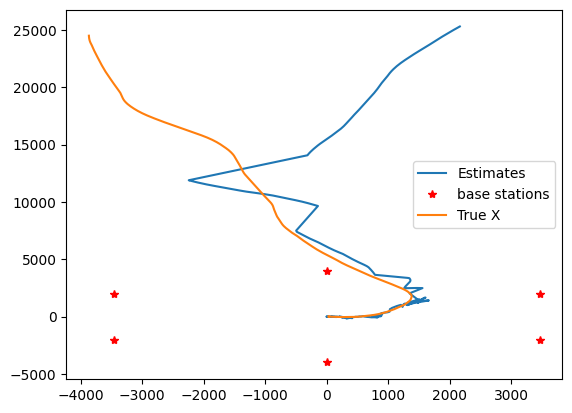

In [ ]:
# Load stations, RSSI, RSSI_unknown_sigma into numpy arrays
# current configuration gives shapes:
# pi.shape = (2, 6)
# pi represents x1, x2 coordinates of the 6 base stations
# Y.shape = Y_sigma.shape = (6, 501)
# Y, Y_sigma represents the received signal strength that the mobile
# unit receives from the 6 base stations at time n < m = 501 
n = 501
X0 = norm.rvs(size=6, scale=np.sqrt([500, 5, 5, 200, 5, 5]))
driving_cmds = np.array([(0, 0), (3.5, 0), (0, 3.5), (0, -3.5), (-3.5, 0)])
# Generate a random index to select a point from the set

sigma = 0.5

W_n = norm.rvs(size=2,scale=[sigma, sigma])
alpha = 0.6
delta_t = 0.5
phi_delta = np.array([[1, delta_t, (delta_t**2/2)], [0, 1, delta_t], [0, 0, alpha]])
phi = np.block([[phi_delta,np.zeros((3,3))], [np.zeros((3,3)),phi_delta]])

psi_delta_z = np.array([delta_t**2/2, delta_t, 0]).reshape((-1, 1))
psi_delta_w = np.array([delta_t**2/2, delta_t, 1]).reshape((-1, 1))
psi_w = np.block([[psi_delta_w,np.zeros((3,1))], [np.zeros((3,1)),psi_delta_w]])
psi_z = np.block([[psi_delta_z,np.zeros((3,1))], [np.zeros((3,1)),psi_delta_z]])

sigma_0 = np.sqrt([500,5,5,200,5,5])

def h(x, pi):
  pos = np.array([x[0], x[3]])
  result = np.zeros((6,))
  for i in range(6):
    result[i] = 30*np.log10(np.linalg.norm(pos - pi[:,i])) - 90 
  return -result



def p(x, y):
  result = np.zeros((6, N))
  
  for i in range(6):
    positions = np.array([x[0] - pi[0,i], x[3] - pi[1,i]]) # (2,N) 
    result[i] = norm.pdf(y[i], loc=-(30*np.log10(np.linalg.norm(positions, axis=0)) - 90), scale=np.sqrt(1.5)) # - pi[:,i]
  return np.product(result, axis=0)

def init(opt = "artificial"):
  global X, Y, pi
  stations = scipy.io.loadmat('stations.mat')
  pi = stations['pos_vec']
  if opt != "artificial": # The actual problem
    mat = scipy.io.loadmat('RSSI-measurements.mat')
    mat2 = scipy.io.loadmat('RSSI-measurements-unknown-sigma.mat')

    Y = mat['Y']
    Y_sigma = mat2['Y']
  elif opt == "artificial": # 

    idx = np.random.randint(0, driving_cmds.shape[0])
    # Select the point at the random index
    Z0 = driving_cmds[idx]
    
    X = np.zeros((6,501))
    Y = np.zeros((6,501))
    
  
    X[:,0] = norm.rvs(size=6, scale=sigma_0) # initialization in stationary distribution
    Y[:,0] = norm.rvs(size=6, loc=h(X[:,0], pi), scale=np.sqrt(1.5))
    for k in range(1,n):
      W_n = norm.rvs(size=2,scale=[sigma, sigma])
      X[:,k] = phi @ X[:,k-1] + psi_z @ Z0 + psi_w @ W_n
      Y[:,k] = norm.rvs(size=6, loc=h(X[:,k], pi), scale=np.sqrt(1.5))
    
      drive_cmd =  np.random.uniform()
      if drive_cmd > 4/5:
        offset = np.random.randint(1, driving_cmds.shape[0])
        idx = (idx + offset) % 5
        Z0 = driving_cmds[idx]

def normalize_wgt(log_weights):
  L = np.max(log_weights)
  w = np.exp(log_weights - L)
  return w/np.sum(w)

init("artificial")
# SIS implementation
N = 1000
M = 1
tau_1 = np.zeros((M,n))
tau_2 = np.zeros((M,n))

for m in range(M):
   # (6, N)
   idx = np.random.randint(0, driving_cmds.shape[0], size=N)
    # Select the point at the random index
   Z0 = driving_cmds[idx].T

   part = np.multiply(norm.rvs(size=6*N).reshape((6,N)), sigma_0[:, np.newaxis])
   wgt = np.zeros((N,n))
   wgt_plt = np.zeros((N,n))
   wgt[:, 0] = np.log(p(part, Y[:,0]))
   #wgt[:, 0] = wgt[:, 0]/np.max(wgt[:, 0])
   wgt_true = normalize_wgt(wgt[:, 0])
   wgt_plt[:, 0] = wgt_true 
  #  print(np.max(wgt_true))

   tau_1[m, 0] = np.sum(part[0] * wgt_true) 
   tau_2[m, 0] = np.sum(part[3] * wgt_true) 
   for k in range(1, n):
      W_n = norm.rvs(size=2*N,scale=sigma).reshape((2,N))
      part = phi @ part + psi_z @ Z0 + psi_w @ W_n

      drive_cmd =  np.random.uniform(size=N)
      offset = np.random.randint(1, driving_cmds.shape[0], size=N)

      drive_cmd[drive_cmd > 4/5] = 1
      drive_cmd[drive_cmd != 1] = 0

      idx = (idx + drive_cmd.astype(int) * offset) % 5
      Z0 = driving_cmds[idx].T

      wgt[:, k] = np.log(p(part, Y[:,k])) + wgt[:, k-1]
      #wgt[:, k] = wgt[:, k]/np.max(wgt[:, k])
      wgt_true = normalize_wgt(wgt[:, k])
      wgt_plt[:, k] = wgt_true
      #print(np.count_nonzero(wgt[:, k]))
      tau_1[m, k] = np.sum(part[0] * wgt_true) 
      tau_2[m, k] = np.sum(part[3] * wgt_true) 

      
# Plotting weight histograms

n_vector = np.array([1, 20, 50, 100])
#bin_pos = np.linspace(-400, 0, 20)
#plt.hist(np.log10(wgt_plt[:, n_vector-1]), bins=bin_pos)
#plt.legend(['n = 1', 'n = 20', 'n = 50', 'n = 100', 'n = 500'], loc='upper left')
#plt.xlabel('Importance weights (base 10 logarithm)')
##plt.ylabel('Absolute frequency')
#plt.title('Importance-weight distribution SIS')

# Efficient sample size at times n
sample_size = np.zeros_like(n_vector)
for k in range(len(n_vector)):
  C = np.sqrt(N*np.sum((wgt_plt[:,n_vector[k]] - 1/N)**2))
  sample_size[k] = N/(1 + C**2)

print(sample_size)

plt.plot(tau_1.T, tau_2.T)
plt.plot(pi[0], pi[1], 'r*')
plt.plot(X[0], X[3])
plt.legend(["Estimates", "base stations", "True X"])
plt.show




(array([0., 1., 2., 3., 4.]), array([ 92,  97, 105, 112,  95]))
3


Text(0.5, 0, 'Time point')

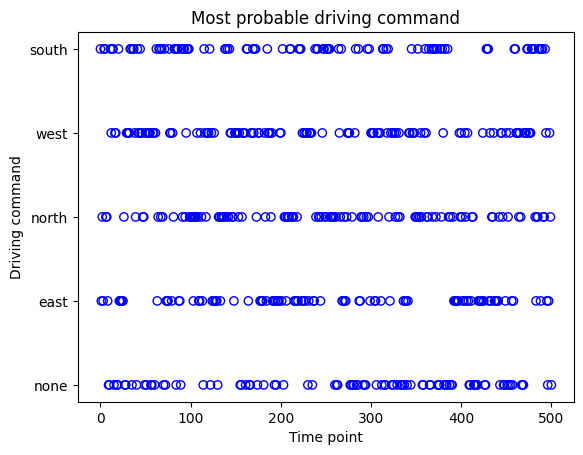

In [ ]:
# SISR
def SISR(Y, sigma):
  global counts
  n = 501
  N = 1000
  M = 1
  tau_1 = np.zeros((M,n))
  tau_2 = np.zeros((M,n))
  sigma_0 = np.sqrt([500,5,5,200,5,5])
  driving_cmds = np.array([(0, 0), (3.5, 0), (0, 3.5), (0, -3.5), (-3.5, 0)])
  stations = scipy.io.loadmat('stations.mat')
  pi = stations['pos_vec']
  tau_1_SISR = np.zeros((M,n))
  tau_2_SISR = np.zeros((M,n))
  N_list = np.array([x for x in range(0,N)])

  
  for m in range(M):
    # (6, N)
    idx = np.random.randint(0, driving_cmds.shape[0], size=N)
      # Select the point at the random index
    Z0 = driving_cmds[idx].T

    counts = np.zeros((n))

    part = np.multiply(norm.rvs(size=6*N).reshape((6,N)),sigma_0[:, np.newaxis])
    wgt = np.zeros((N,n))
    wgt_ = np.zeros((N,n))
    wgt_[:, 0] = p(part, Y[:,0])
    wgt[:, 0] = np.log(wgt_[:, 0])
    wgt_true = normalize_wgt(wgt[:,0])

    tau_1_SISR[m, 0] = np.sum(part[0] * wgt_true)
    tau_2_SISR[m, 0] = np.sum(part[3] * wgt_true)
    
    ind = choices(N_list, weights=wgt_true, k=N)
    counts[0] = np.argmax(np.bincount(idx[ind]))
    for k in range(1, n):
        W_n = norm.rvs(size=2*N,scale=sigma).reshape((2,N))
        
        part = part[:,ind]
        part = phi @ part + psi_z @ Z0 + psi_w @ W_n

        drive_cmd =  np.random.uniform(size=N)
        offset = np.random.randint(1, driving_cmds.shape[0], size=N)

        drive_cmd[drive_cmd > 4/5] = 1
        drive_cmd[drive_cmd != 1] = 0

        idx = (idx + drive_cmd.astype(int) * offset) % 5
        counts[k] = np.argmax(np.bincount(idx[ind])) # Calculate the most frequent command among all particles per time step

        Z0 = driving_cmds[idx].T # (0,0), (3.5,0) .. N st 


        #temp = np.unique(Z0, return_counts=True) # (2, 5)

        wgt_[:, k] = (p(part, Y[:,k]))
        wgt[:, k] = np.log(wgt_[:, k])
        
        wgt_true = normalize_wgt(wgt[:, k])
        #print(np.count_nonzero(wgt[:, k]))
        tau_1_SISR[m, k] = np.sum(part[0] * wgt_true) 
        tau_2_SISR[m, k] = np.sum(part[3] * wgt_true) 
        
        ind = choices(N_list, weights=wgt_true, k=N)
    return tau_1_SISR, tau_2_SISR, wgt_
      
      
# # Plotting weight histograms

# n_vector = np.array([1, 20, 50, 100, 500])
# bin_pos = np.linspace(-400, 0, 20)
# plt.hist(np.log10(wgt[:, n_vector-1]), bins=bin_pos)
# plt.legend(['n = 1', 'n = 20', 'n = 50', 'n = 100', 'n = 500'], loc='upper left')
# plt.xlabel('Importance weights (base 10 logarithm)')
# plt.ylabel('Absolute frequency')
# plt.title('Importance-weight distribution SIS')

sigma = 1.5
tau_1_SISR,tau_2_SISR, l = SISR(Y, sigma)
#plt.plot(tau_1_SISR.T, tau_2_SISR.T)
#plt.plot(pi[0], pi[1], 'r*')
##plt.plot(X[0], X[3])
#plt.legend(["Estimates", "base stations", "True X"])
#plt.show
  #wgt[:, :, 0] = norm.pdf(Y[:,0], loc=np.product(h(part, pi)), scale=np.sqrt(1.5))

  # tau[m, 0] = np.sum(part * wgt[:, 0]) / np.sum(wgt[:, 0])

  # for k i range(1,n):

print(np.unique(counts, return_counts=True))
print(np.argmax(np.unique(counts, return_counts=True)[1]))
#plt.plot(counts)
fig, ax = plt.subplots(1,1)
# plt.figure(figsize=(10,7))
ax.scatter([i for i in range(n)],counts, facecolors='none', edgecolors='b')
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['none', 'east', 'north', 'west', 'south'])
ax.set_title('Most probable driving command')
ax.set_ylabel('Driving command')
ax.set_xlabel('Time point')

sigma_hat 2.625


<function matplotlib.pyplot.show(close=None, block=None)>

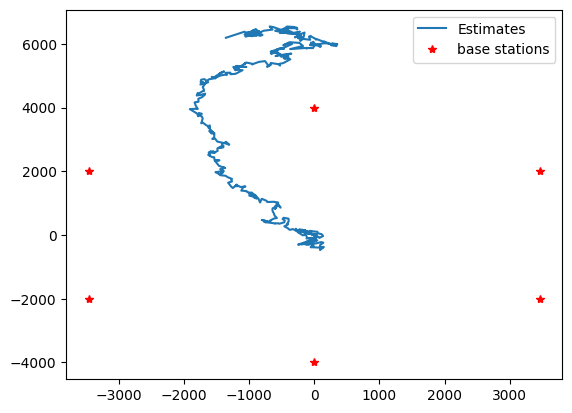

In [ ]:
#P5

mat2 = scipy.io.loadmat('RSSI-measurements-unknown-sigma.mat')

Y = mat2['Y']
h = 0.0625

sigma_list = np.arange(h, 3, h)

log_like = np.zeros((len(sigma_list)))

#def log_likelihood(y, sigma):
#    tau1,tau2, w = SISR(y, sigma)
#    return np.sum((np.sum(w, axis=0)))

def log_likelihood(y, sigma):
    tau1,tau2, w = SISR(y, sigma)
    
    result = (1/n)* (np.sum(np.log(np.sum(w, axis=0))) - np.log(N))
    return result

for i, sigma in enumerate(sigma_list):
 log_like[i] = log_likelihood(Y, sigma)


sigma_hat = sigma_list[np.argmax(log_like)]
print("sigma_hat", sigma_hat)
#print(log_like)
tau1, tau2, w = SISR(Y, sigma_hat)

#print(tau1, tau2)

plt.plot(tau1.T, tau2.T)
plt.plot(pi[0], pi[1], 'r*')
plt.legend(["Estimates", "base stations"])
plt.show




